# Calculation Part

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [11]:
def load_images(folder):
    images = []
    labels = []
    class_dirs = ['Carambula', 'Lychee', 'Pear']
    for idx, fruit in enumerate(class_dirs):
        fruit_path = os.path.join(folder, fruit)
        for image_name in os.listdir(fruit_path):
            image_path = os.path.join(fruit_path, image_name)
            img = Image.open(image_path).convert('L')
            img = np.array(img).flatten()
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)


def preprocess_data(data_folder, pca_components):
    X_train, y_train = load_images(os.path.join(data_folder, 'Data_train'))
    X_test, y_test = load_images(os.path.join(data_folder, 'Data_test'))

    # Normalize the data
    X_train = X_train / 255
    X_test = X_test / 255

    # Perform PCA
    pca = PCA(n_components=pca_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Add bias term
    X_train_pca = np.hstack((X_train_pca, np.ones((X_train_pca.shape[0], 1))))
    X_test_pca = np.hstack((X_test_pca, np.ones((X_test_pca.shape[0], 1))))

    return X_train_pca, X_test_pca, y_train, y_test


def one_hot_encode(y, num_classes):
    y_one_hot = np.zeros((len(y), num_classes))
    unique_labels = np.unique(y)
    for i, label in enumerate(unique_labels):
        y_one_hot[y == label, i] = 1
    return y_one_hot


def sigmoid(x):
    x = np.clip(x, -500, 500)  # Limit the input values to avoid overflow
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)


class ThreeLayerNN:
    def __init__(self, input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes):
        self.input_nodes = input_nodes
        self.hidden_nodes_1 = hidden_nodes_1
        self.hidden_nodes_2 = hidden_nodes_2
        self.output_nodes = output_nodes
        self.loss_arr = []

        self.weights1 = np.random.randn(input_nodes, hidden_nodes_1)
        self.weights2 = np.random.randn(hidden_nodes_1, hidden_nodes_2)
        self.weights3 = np.random.randn(hidden_nodes_2, output_nodes)
        self.bias1 = np.random.randn(1, self.hidden_nodes_1)
        self.bias2 = np.random.randn(1, self.hidden_nodes_2)
        self.bias3 = np.random.randn(1, self.output_nodes)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.layer1 = sigmoid(np.dot(X, self.weights1) + self.bias1)
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2) + self.bias2)
        output = self.softmax(np.dot(self.layer2, self.weights3) + self.bias3)
        return output

    def backprop(self, X, y, output, learning_rate=0.001):
        self.layer3_error = y - output
        self.layer3_delta = self.layer3_error * sigmoid_derivative(output)

        self.layer2_error = np.dot(self.layer3_delta, self.weights3.T)
        self.layer2_delta = self.layer2_error * sigmoid_derivative(self.layer2)

        self.layer1_error = np.dot(self.layer2_delta, self.weights2.T)
        self.layer1_delta = self.layer1_error * sigmoid_derivative(self.layer1)

        self.weights1 += learning_rate * np.dot(X.T, self.layer1_delta)
        self.weights2 += learning_rate * \
            np.dot(self.layer1.T, self.layer2_delta)
        self.weights3 += learning_rate * \
            np.dot(self.layer2.T, self.layer3_delta)

    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = len(y_true)
        y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
        loss = -np.sum(y_true * np.log(y_pred_clipped)) / n_samples
        return loss

    def train(self, X, y, epochs=1000, learning_rate=0.001, batch_size = 16):
        for epoch in range(epochs):
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            for start_idx in range(0, len(X), batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                X_batch, y_batch = X[batch_indices], y[batch_indices]
            
                output_batch = self.forward(X_batch)
                
                self.backprop(X_batch, y_batch, output_batch, learning_rate)
                
            loss = self.cross_entropy_loss(y_batch, output_batch)
            self.loss_arr.append(loss)
            if epoch % 100 == 0:
                    print(f'loss: {loss}')

    def predict(self, X):
        output = self.forward(X)
        predictions = np.argmax(output, axis=1)
        return predictions
    
    def plot_loss(self):
        plt.plot(self.loss_arr, 'r-', label='training loss')
        plt.xlabel('Epoch(s)')
        plt.ylabel('Cross-entropy loss')
        plt.legend()
        plt.show()

    def plot_decision_regions(self, X, y, label):
        # Create a grid of points
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                            np.arange(y_min, y_max, 0.1))

        # Flatten the grid points and add a column of ones for the bias term
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_points = np.hstack((grid_points, np.ones((grid_points.shape[0], 1))))

        # Pass the grid points through the neural network
        output = self.forward(grid_points)
        predictions = np.argmax(output, axis=1)

        # Reshape the predictions to match the grid shape
        predictions = predictions.reshape(xx.shape)

        # Plot the decision regions
        plt.contourf(xx, yy, predictions, alpha=0.3)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=80)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(label)
        plt.show() 


def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)

    data_size = len(X)
    indices = np.arange(data_size)
    np.random.shuffle(indices)

    split_index = int(data_size * (1 - test_size))
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


def accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

In [12]:
# Load and preprocess your dataset (PCA and train-validation split)
data_folder = 'Data'
pca_components = 2

X_train, X_test, y_train, y_test = preprocess_data(data_folder, pca_components)
X_train, X_val, y_train, y_val = custom_train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

num_classes = 3
y_train_one_hot = one_hot_encode(y_train, num_classes)
y_val_one_hot = one_hot_encode(y_val, num_classes)

# Define neural network parameters
input_nodes = 3  # Two principal components plus bias
hidden_nodes_1 = 256
hidden_nodes_2 = 64
output_nodes = 3

# Create and train the neural network
nn = ThreeLayerNN(input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes)
nn.train(X_train, y_train_one_hot, epochs=1000)

# Evaluate the model's performance on the validation data
y_val_pred = nn.predict(X_val)
val_accuracy = accuracy(y_val, y_val_pred)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

loss: 2.7523622871131357
loss: 0.24142248820059248
loss: 0.3101172041760206
loss: 0.12113487318777846
loss: 0.707933779586448
loss: 0.09360982947193738
loss: 0.2643317286216411
loss: 0.09232131406505795
loss: 0.11362580186992652
loss: 0.07493977398746153
Validation accuracy: 94.90%


# Accuracy Part

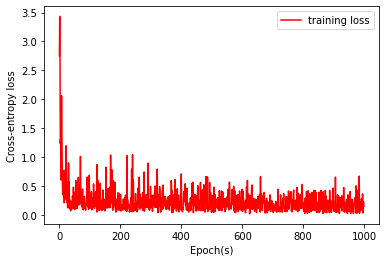

In [13]:
nn.plot_loss()

# Decision Part

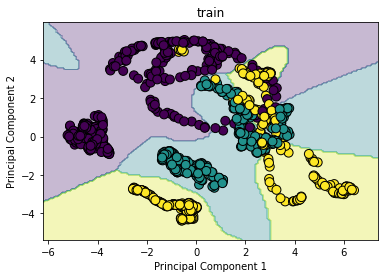

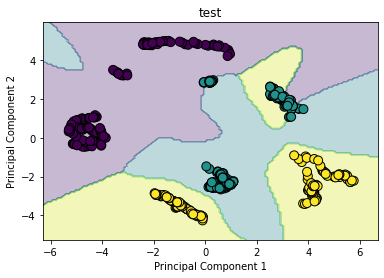

In [14]:
nn.plot_decision_regions(X_train, y_train, label='train')
nn.plot_decision_regions(X_test, y_test, label='test')

# Batch Size

--Train batch_sizes = 8 start--
loss: 6.634815695363182
loss: 0.6290541684128761
loss: 0.0815098159538833
loss: 0.10820134845934562
loss: 0.047197980548236415
--Train batch_sizes = 16 start--
loss: 2.9573455693918564
loss: 0.18947253150094834
loss: 0.16829331104414333
loss: 0.36200075403634535
loss: 0.22115881465653953
--Train batch_sizes = 32 start--
loss: 5.98925968643167
loss: 0.2868020923664278
loss: 0.20565238830728935
loss: 0.10373863164562165
loss: 0.30278019350896024
--Train batch_sizes = 64 start--
loss: 3.7439459335941563
loss: 0.15804004816798314
loss: 0.24559556846661776
loss: 0.1133503260483059
loss: 0.1387240924998679


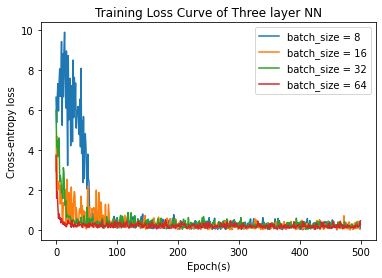

In [15]:
batch_sizes = [2**i for i in range(3, 7)]
for batch_size in batch_sizes:
    print(f'--Train batch_sizes = {batch_size} start--')
    nn = ThreeLayerNN(input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes)
    nn.train(X_train, y_train_one_hot, epochs=500, batch_size=batch_size)
    plt.plot(nn.loss_arr, label=f'batch_size = {batch_size}')
plt.title(f'Training Loss Curve of Three layer NN')
plt.xlabel('Epoch(s)')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Hidden Layer Size

--Train hidden_1_size = 16
--Train hidden_2_size = 16 start--
loss: 3.539470407041648
loss: 0.46086843229062774
loss: 0.3840111259213888
loss: 0.33271611480638774
loss: 0.2617453464165403
--Train hidden_2_size = 32 start--
loss: 2.1502502068747655
loss: 0.3372453983880191
loss: 0.4641220900512783
loss: 0.4687281168833192
loss: 0.4175982187818276
--Train hidden_2_size = 64 start--
loss: 2.2714189146037773
loss: 0.44399927736836986
loss: 0.35097263419084174
loss: 0.49067449806730506
loss: 0.3586579298080834
--Train hidden_2_size = 128 start--
loss: 10.283779149527188
loss: 8.454450271386397
loss: 8.065919745129731
loss: 0.43514471373803226
loss: 0.20522348955608208


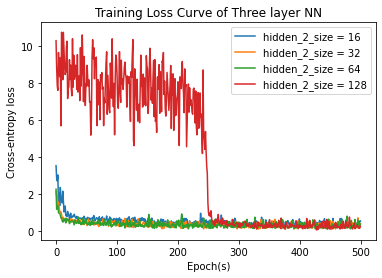

--Train hidden_1_size = 32
--Train hidden_2_size = 16 start--
loss: 3.1005021565839077
loss: 0.45124054269268044
loss: 0.3374924751004609
loss: 0.4651955551214029
loss: 0.40470015292082934
--Train hidden_2_size = 32 start--
loss: 2.4776441005208976
loss: 0.25298823934263864
loss: 0.4184216693583967
loss: 0.5182453701558439
loss: 0.1272549675803226
--Train hidden_2_size = 64 start--
loss: 5.310904990809256
loss: 0.36020998265231974
loss: 0.24223563518855232
loss: 0.3156163784628445
loss: 0.14830683142908826
--Train hidden_2_size = 128 start--
loss: 2.1065419816342157
loss: 0.15222352023844032
loss: 0.7269593157616003
loss: 0.27185843838866286
loss: 0.09465134417605085


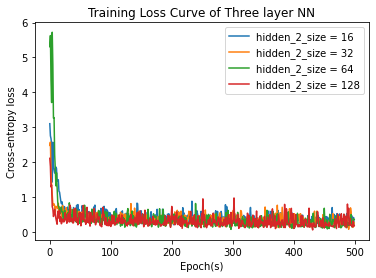

--Train hidden_1_size = 64
--Train hidden_2_size = 16 start--
loss: 2.7407215806134295
loss: 0.4474225832500239
loss: 0.37255993531102777
loss: 0.46040858724268524
loss: 0.2408656275962752
--Train hidden_2_size = 32 start--
loss: 2.948923653836029
loss: 0.26336903593409816
loss: 0.21992626642806265
loss: 0.5348928900350095
loss: 0.3334425303358641
--Train hidden_2_size = 64 start--
loss: 1.5283348750161114
loss: 0.19644520712237093
loss: 0.20544368495391815
loss: 0.8052840079913967
loss: 0.31744475636606645
--Train hidden_2_size = 128 start--
loss: 8.335518966230469
loss: 0.4600906320085902
loss: 0.1018718984959448
loss: 0.24519919425848402
loss: 0.5459639379782323


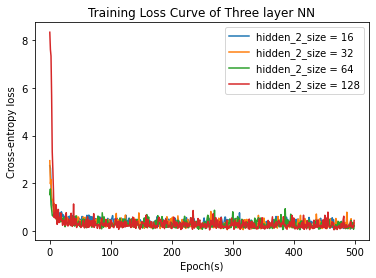

--Train hidden_1_size = 128
--Train hidden_2_size = 16 start--
loss: 1.2978124432292202
loss: 0.4140966146524086
loss: 0.4600877433102539
loss: 0.37713915535260084
loss: 0.24631974411330412
--Train hidden_2_size = 32 start--
loss: 2.4053226752913583
loss: 0.3527983565305344
loss: 0.1419002082827829
loss: 0.35318383719152413
loss: 0.47074517768011925
--Train hidden_2_size = 64 start--
loss: 3.3295122871377774
loss: 0.1105767113638786
loss: 0.15075349557305792
loss: 0.33211418121335123
loss: 0.08109395981852068
--Train hidden_2_size = 128 start--
loss: 7.992530806907985
loss: 0.4957816137119276
loss: 0.16713264891656401
loss: 0.17174806554578478
loss: 0.14297336366819946


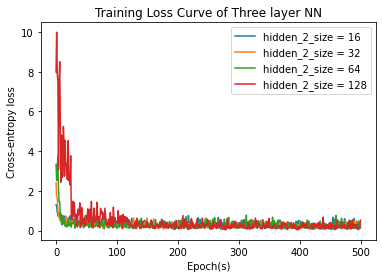

In [17]:
hidden_1_sizes = [2**i for i in range(4, 8)]
hidden_2_sizes = [2**i for i in range(4, 8)]
for hidden_1_size in hidden_1_sizes:
    print(f'--Train hidden_1_size = {hidden_1_size}')
    for hidden_2_size in hidden_2_sizes:
        print(f'--Train hidden_2_size = {hidden_2_size} start--')
        nn = ThreeLayerNN(input_nodes, hidden_1_size, hidden_2_size, output_nodes)
        nn.train(X_train, y_train_one_hot, epochs=500, batch_size=32)
        plt.plot(nn.loss_arr, label=f'hidden_2_size = {hidden_2_size}')
    plt.title(f'Training Loss Curve of Three layer NN')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()